# Gangs Matrix - Validation

*Toby Davies*

This notebook presents some validation of the 'shuffle' analytical approach via its application to synthetic data.

Synthetic data is created with known properties - it replicates the observed Gangs Matrix data in terms of the offending rate over time, but with a known reduction of offending after entry to the Matrix. The shuffle approach is then applied to this data to see whether the (known) effect is evident.

## Data loading and preparation

Some initial package imports to work with the data:

In [1]:
import pandas as pd
import numpy as np
# import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline
# mpl.rcParams['figure.dpi'] = 200
import stats.synthesis as synth
import stats.shuffle as shuffle

Set up some plotting parameters.

In [2]:
sns.set_theme(style='whitegrid', font='Bahnschrift', font_scale=1.2)
sns.set_style({"grid.color": ".8"})

Read the base data file - print first 2 rows to check validity.

In [3]:
# Use the URN as the index
# Sheet name selects Excel sheet - 0 for raw counts, 1 for binary alternative
data = pd.read_excel("A:/UCLMaster_V2.xlsx", sheet_name=1, index_col='URN')
# data = pd.read_excel("/Volumes/MOPAC Data/UCLMaster_V2.xlsx", sheet_name=1, index_col='URN')
data.head(2)

,END,FirstOn-1,LastOn+1,AgeOnMatrix,PreMths,DuringMths,PostMths,Pre48,Pre47,Pre46,...,Post39,Post40,Post41,Post42,Post43,Post44,Post45,Post46,Post47,Post48
URN,,,,,,,,,,,,,,,,,,,,,
1,2017-10-31,2015-05-01,2016-04-01,28,221,11,19.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-10-31,2013-07-01,2018-03-01,27,209,52,NaN,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Data loaded successfully.

We now pre-process the data in exactly the same way as in the basic analysis - see main notebook for explanation of the steps.

In [4]:
# Count how many valid values for each time period
data['ValidPre'] = data.loc[:,'Pre48':'Pre1'].count(axis=1)
data['ValidDur'] = data.loc[:,'Dur1':'Dur63'].count(axis=1)
data['ValidPost'] = data.loc[:,'Post1':'Post48'].count(axis=1)
data['ValidAll'] = data.loc[:,'Pre48':'Post48'].count(axis=1)

# Fill missing values of PostMths with zeros
data['PostMths'] = data['PostMths'].fillna(0)

data['PreDurMths'] = data['PreMths'] + data['DuringMths']

# Note the first valid month in the data, measured from 10th birthday
# Month columns are measured SINCE this - first valid PreXX is 0 months after StartMth
data['StartMth'] = data['PreMths'] - data['ValidPre']

# EndMth will be one after the last valid month in the data (i.e. the next missing month)
data['EndMth'] = data['StartMth'] + data['ValidAll']

histories_raw = data.loc[:, 'Pre48': 'Post48'].T

histories_continuous = {}
for urn in histories_raw:
    history = histories_raw[urn].dropna()
    history.index = np.arange(data.loc[urn,'StartMth'], data.loc[urn,'EndMth'])
    histories_continuous[urn] = history
histories = pd.DataFrame(histories_continuous)

## Properties of observed data

Since the aim here is to generate synthetic data that matches the properties of the observed data, need to derive these properties.

Start with the sanction rate over time.

In [5]:
sanction_rates = histories.mean(axis=1)

Plot the evolution of this over time - the synthetic population will match this rate.

Text(0, 0.5, 'Proportion sanctioned')

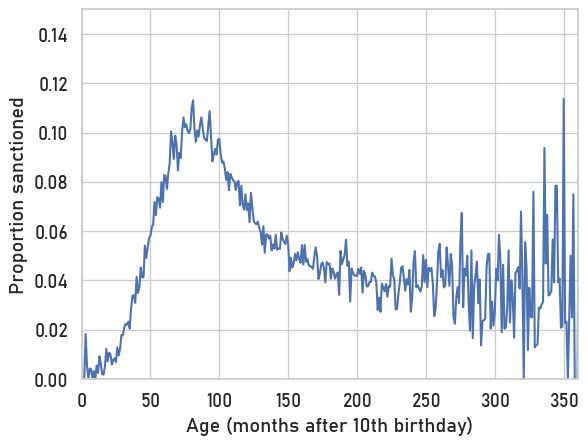

In [6]:
sanction_rates.plot()
plt.xlim(0,360)
plt.ylim(0, 0.15)
plt.xlabel('Age (months after 10th birthday)')
plt.ylabel('Proportion sanctioned')

Also examine the distribution of entry points.

In [7]:
entry_points = data['PreMths']

Plot this too...

Text(0, 0.5, 'Proportion entering (%)')

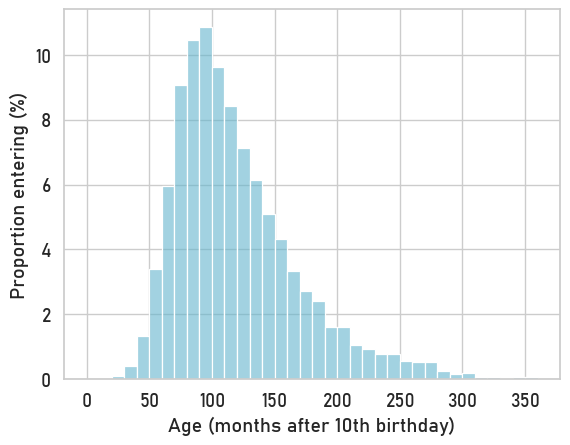

In [8]:
ax = sns.histplot(entry_points, binrange=[0,360], bins=36, stat='percent', color='c', alpha=0.6, label='Entry point')
ax.set_xlabel('Age (months after 10th birthday)')
ax.set_ylabel('Proportion entering (%)')

## Simulate data

Now apply the test to some simulated data. 

### No treatment effect

In the first instance we will simulate some data with no treatment effect at all - simply a population that matches the observed population rate in terms of sanction rate by age.

Start by saying how many we want to simulate.

In [9]:
n_people = 2000

First determine matrix entry points. Sample these with replacement from the observed data.

In [10]:
entry_points_synth = entry_points.sample(n=n_people, replace=True).reset_index(drop=True)
print(entry_points_synth)

0       239
1        82
2        79
3        63
4        78
       ... 
1995    132
1996     88
1997    127
1998    123
1999     83
Name: PreMths, Length: 2000, dtype: int64


Now simulate their sanctions. Build array of sanction rates with one column for each individual, each with sanction rates equal to that in the overall population.

In [11]:
sanction_rates_synth = np.tile(sanction_rates.values[:, np.newaxis], (1, n_people))
print(sanction_rates_synth.shape)

(583, 2000)


Now sample Poisson for every person-month, with rate given by the sanction rate. Convert these to dichotomous values to get a binary indicator of sanction.

In [12]:
rng = np.random.default_rng()
histories_synth = rng.poisson(sanction_rates_synth) > 0
histories_synth = pd.DataFrame(histories_synth.astype(int))

histories_synth

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
579,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
580,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Check the sanction rate by age looks sensible.

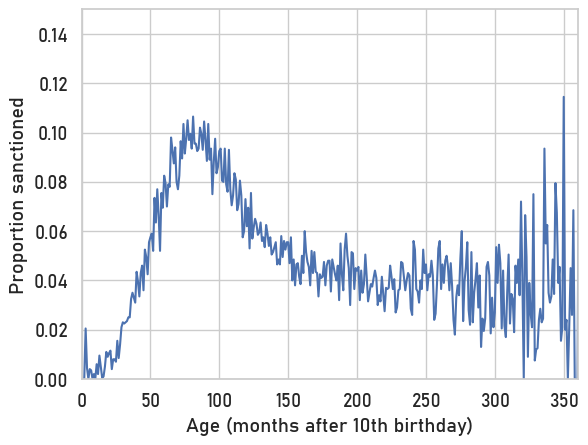

In [13]:
histories_synth.mean(axis=1).plot()
plt.xlim(0,360)
plt.ylim(0, 0.15)
plt.xlabel('Age (months after 10th birthday)')
plt.ylabel('Proportion sanctioned');

It does - it broadly reflects the observed rate.

Now plot the sanction rate with respect to Matrix entry point - i.e. months pre and post. Note that this data includes no treatment effect.

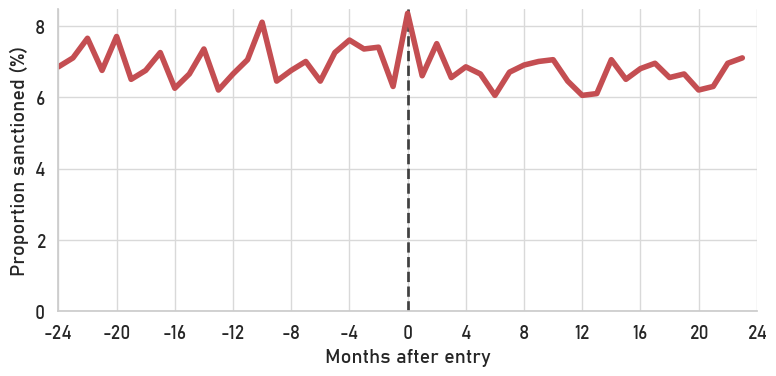

In [14]:
# Some aesthetic definitions
sns.set_style({"grid.color": ".85"})

# Align the histories according to 'PreMths'
# This means all columns are aligned with respect to Matrix entry point
histories_aligned = shuffle.align_data_buff(histories_synth, entry_points_synth, 24, 24)
#Calculate the means for each row, scaled as percentages
observed_rates = histories_aligned.mean(axis=1) * 100

#Initialise figure
fig, ax = plt.subplots(figsize=(8, 4))

# Plot sanction rates by month
observed_rates.plot(ylim=(0), color='r', lw=4, ax=ax)
# Add a reference line at entry point
ax.axvline(0, color ='k', ls='--', lw=2, alpha=0.8, zorder=1)

# Adjust limits and labels
ax.set_xlim(-24,24)
ax.set_xticks(range(-24,25,4))
ax.set_xticklabels([x.get_text().replace('−', '-') for x in ax.get_xticklabels()])
ax.set_xlabel('Months after entry')
ax.set_ylabel('Proportion sanctioned (%)')

# Tidy up figure and save
sns.despine()
plt.tight_layout()

As expected, we see no clear change with respect to the treatment time. There is a small decrease over time, consistent with the overall decrease in offending rate with age (i.e. age-crime curve).

Now apply the shuffle test to this data. Calculate the rates for multiple shuffled datasets.

In [15]:
perm_rates = shuffle.permuted_rates(histories_synth, entry_points_synth, 24, 24, 99)

Plot these rates against the original observed rates.

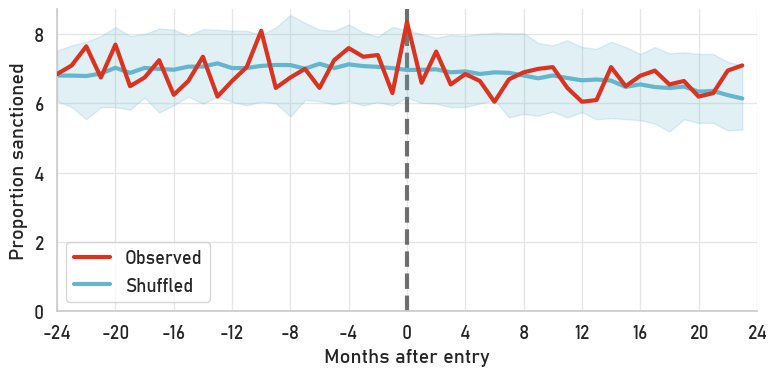

In [16]:
# Aesthetic settings
sns.set_style({"grid.color": ".9"})

# Multiply rates by 100 to express as percentages
perm_percs = perm_rates * 100
# Calculate the mean across all shuffles
perm_mean = perm_percs.mean(axis=0)
perm_std = perm_percs.std()
perm_sem = perm_percs.sem()
# ...and the quantiles
quantiles = perm_percs.quantile([0.025, 0.975])

# Initialise figure
fig, ax = plt.subplots(figsize=(8, 4))

#Plot the observed rates and the mean shuffled rates as lines
observed_rates.plot(label='Observed', color='#DC3220', lw=3, zorder=3, ax=ax)
perm_mean.plot(xlim=(-24,23), c='c', lw=3, label='Shuffled', zorder=2, ax=ax)

#Plot a tube representing the quantiles
ax.fill_between(perm_mean.index, quantiles.loc[0.025, :], quantiles.loc[0.975, :], color='c', alpha=0.2, zorder=1.5)

# Add legend and line to represent entry point
plt.legend()
ax.axvline(0, color ='0.3', ls='--', lw=3, alpha=0.8, zorder=1)

# Set limits and ticks
ax.set_ylim(0)
ax.set_xticks(range(-24,25,4))
ax.set_xticklabels([x.get_text().replace('−', '-') for x in ax.get_xticklabels()])
ax.set_xlabel('Months after entry')
ax.set_ylabel('Proportion sanctioned')

# Tidy up figure and save
sns.despine()
plt.tight_layout()

There is no effect - the observed data is entirely consistent with the shuffled data. This is as it should be - the data were simulated so that there was no treatment effect, and so we have (correctly) failed to identify one.

### Treatment effect

Now try simulating some fake data with a treatment effect.

Begin by simulating the Matrix entry points, sampling with replacement from the real data.

In [17]:
entry_points_synth = entry_points.sample(n=n_people, replace=True).reset_index(drop=True)

Then set the sanction rates to match the real data.

In [18]:
sanction_rates_synth = np.tile(sanction_rates.values[:, np.newaxis], (1, n_people))

Specify a parameter to determine the effect size - this will act multiplicatively on the offending rate - so a treatment of effect of X implies a (1-X)*100% reduction.

In [19]:
treatment_factor = 0.8

Simulate offending histories with this treatment effect applied.

In [20]:
# Get the indices for the months and individuals
month_index, person_index = np.indices(sanction_rates_synth.shape)
# Create a mask - for each column, values are True for rows higher than corresponding entry point
mask = month_index >= entry_points_synth.values
# Multiply the post-entry sanction rates by the treatment factor
sanction_rates_synth[mask] *= treatment_factor
# Generate synthetic histories using Poisson distribution with specified rates
histories_synth = rng.poisson(sanction_rates_synth) > 0
# Convert this to DataFrame
histories_synth = pd.DataFrame(histories_synth.astype(int))
# Print the histories
histories_synth

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
579,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
580,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Plot the offending rate by age.

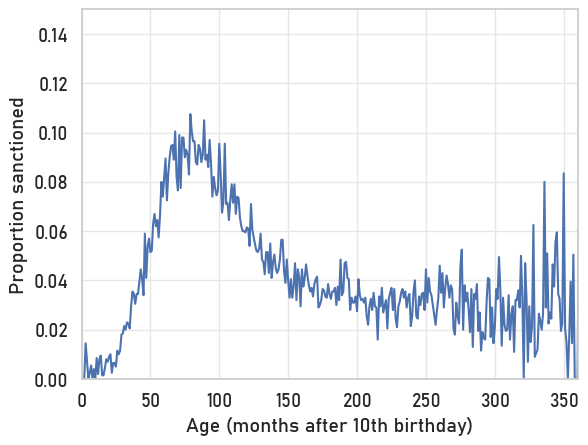

In [21]:
histories_synth.mean(axis=1).plot()
plt.xlim(0,360)
plt.ylim(0, 0.15)
plt.xlabel('Age (months after 10th birthday)')
plt.ylabel('Proportion sanctioned');

Then plot the offending rate with respect to Matrix entry.

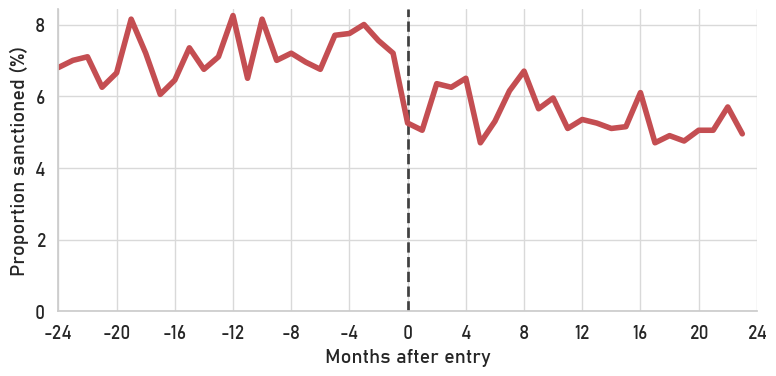

In [22]:
# Some aesthetic definitions
sns.set_style({"grid.color": ".85"})

# Align the histories according to 'PreMths'
# This means all columns are aligned with respect to Matrix entry point
histories_aligned = shuffle.align_data_buff(histories_synth, entry_points_synth, 24, 24)
#Calculate the means for each row, scaled as percentages
observed_rates = histories_aligned.mean(axis=1) * 100

#Initialise figure
fig, ax = plt.subplots(figsize=(8, 4))

# Plot sanction rates by month
observed_rates.plot(ylim=(0), color='r', lw=4, ax=ax)
# Add a reference line at entry point
ax.axvline(0, color ='k', ls='--', lw=2, alpha=0.8, zorder=1)

# Adjust limits and labels
ax.set_xlim(-24,24)
ax.set_xticks(range(-24,25,4))
ax.set_xticklabels([x.get_text().replace('−', '-') for x in ax.get_xticklabels()])
ax.set_xlabel('Months after entry')
ax.set_ylabel('Proportion sanctioned (%)')

# Tidy up figure and save
sns.despine()
plt.tight_layout()

We see a clear reduction, consistent with the treatment effect.

Now apply the shuffle procedure to this data.

In [23]:
perm_rates = shuffle.permuted_rates(histories_synth, entry_points_synth, 24, 24, 99)

Plot the 'observed' rates against the equivalent rates from the shuffled data.

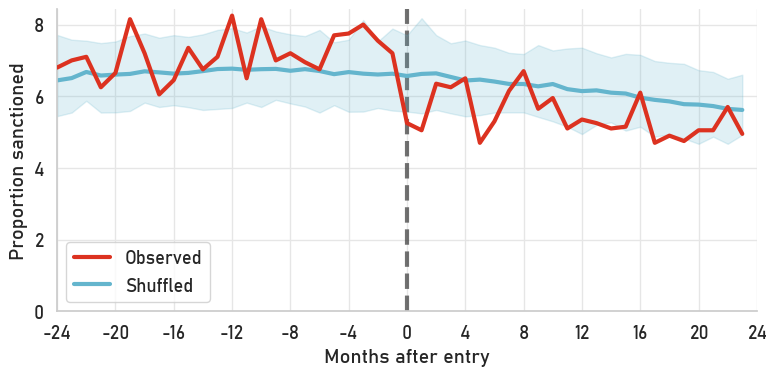

In [24]:
# Aesthetic settings
sns.set_style({"grid.color": ".9"})

# Multiply rates by 100 to express as percentages
perm_percs = perm_rates * 100
# Calculate the mean across all shuffles
perm_mean = perm_percs.mean(axis=0)
perm_std = perm_percs.std()
perm_sem = perm_percs.sem()
# ...and the quantiles
quantiles = perm_percs.quantile([0.025, 0.975])

# Initialise figure
fig, ax = plt.subplots(figsize=(8, 4))

#Plot the observed rates and the mean shuffled rates as lines
observed_rates.plot(label='Observed', color='#DC3220', lw=3, zorder=3, ax=ax)
perm_mean.plot(xlim=(-24,23), c='c', lw=3, label='Shuffled', zorder=2, ax=ax)

#Plot a tube representing the quantiles
ax.fill_between(perm_mean.index, quantiles.loc[0.025, :], quantiles.loc[0.975, :], color='c', alpha=0.2, zorder=1.5)

# Add legend and line to represent entry point
plt.legend()
ax.axvline(0, color ='0.3', ls='--', lw=3, alpha=0.8, zorder=1)

# Set limits and ticks
ax.set_ylim(0)
ax.set_xticks(range(-24,25,4))
ax.set_xticklabels([x.get_text().replace('−', '-') for x in ax.get_xticklabels()])
ax.set_xlabel('Months after entry')
ax.set_ylabel('Proportion sanctioned')

# Tidy up figure and save
sns.despine()
plt.tight_layout()

We see that the method detects the effect - regions where the Observed line falls outside the 'tube' are those where the observed rate of offending is inconsistent with the null hypothesis of no treatment effect.